In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from transformers import ViTModel
from torch.optim import Adam
from PIL import Image
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
     
#   بارگذاری داده ها از پوشه ها
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# بارگذاری داده ها با ImageFolder
train_dataset = ImageFolder(train_dir)
val_dataset = ImageFolder(val_dir)
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset
train_triplet_dataset = TripletDatasetFinal(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

val_triplet_dataset = TripletDatasetFinal(val_dataset)
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=True)

test_triplet_dataset = TripletDatasetFinal(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

#   تعریف مدل، Optimizer و Loss Function
model_name = "google/vit-base-patch16-224"
model = ViTWithAttention(model_name)
optimizer = Adam(model.parameters(), lr=1e-5)
triplet_loss = TripletLossFinal(margin=1.0)

#   آموزش مدل و محاسبه Accuracy
num_epochs = 1
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        anchor, positive, negative,anchor_label = batch

        # استخراج ویژگی ها (embeddings)
        anchor_features,_ = model(anchor)
        positive_features,_ = model(positive)
        negative_features,_ = model(negative)

        # محاسبه ی loss
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        epoch_loss += loss.item()

        # محاسبه accuracy
        distance_positive = F.pairwise_distance(anchor_features, positive_features)
        distance_negative = F.pairwise_distance(anchor_features, negative_features)
        predictions = (distance_positive < distance_negative).float()  # 1 اگر درست، 0 اگر نادرست
        correct += predictions.sum().item()
        total += predictions.size(0)

        # به روزرسانی مدل
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = correct / total
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")

#   ذخیره سازی مدل Fine-Tuned
#torch.save(model.state_dict(), "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth")
#torch.save(model, "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth")
torch.save(model.state_dict(), "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth")
torch.save(model, "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth")

    

C:\Users\Mey\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mey\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\Mey\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\Mey\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resum

Epoch 1, Loss: 0.3142583779990673, Accuracy: 89.78%


In [2]:
# تعداد کلاس ها
num_classes = len(train_dataset.classes)
print(f"تعداد کلاس ها: {num_classes}")

# لیست کلاس ها
classes = train_dataset.classes
print(f"کلاس ها: {classes}")

# تعداد نمونه ها در هر کلاس
class_counts = {cls: 0 for cls in classes}
for target in train_dataset.targets:
    class_counts[classes[target]] += 1

print("تعداد نمونه ها در هر کلاس:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


تعداد کلاس ها: 15
کلاس ها: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
تعداد نمونه ها در هر کلاس:
Pepper__bell___Bacterial_spot: 15
Pepper__bell___healthy: 15
Potato___Early_blight: 15
Potato___Late_blight: 15
Potato___healthy: 15
Tomato_Bacterial_spot: 15
Tomato_Early_blight: 15
Tomato_Late_blight: 15
Tomato_Leaf_Mold: 15
Tomato_Septoria_leaf_spot: 15
Tomato_Spider_mites_Two_spotted_spider_mite: 15
Tomato__Target_Spot: 15
Tomato__Tomato_YellowLeaf__Curl_Virus: 15
Tomato__Tomato_mosaic_virus: 15
Tomato_healthy: 15


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from metrics import MetricsFinal
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal


# بارگذاری مدل ( مدل قبلاً آموزش دیده و ذخیره شده است)
model = ViTWithAttention("google/vit-base-patch16-224")
#model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن‌های مدل
model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن‌های مدل

# استفاده از کد ارزیابی
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# باید test_loader در دسترس باشد
MetricsFinal.evaluate_triplet_model(model, test_loader, device)


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Mey\AppData\Local\Temp\ipykernel_824\2657542289.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor

Accuracy: 84.91%
Precision: 1.00
Recall: 0.85
F1 Score: 0.92


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.849065760737685, 1.0, 0.849065760737685, 0.9183727034120734)

C:\Users\pc\AppData\Local\Temp\ipykernel_380\1500588020.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)  # تبدیل برچسب‌ها به tensor و انتقال به دستگاه


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


C:\Users\pc\AppData\Local\Temp\ipykernel_380\1500588020.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))  # خودکار انتخاب رنگ‌ها


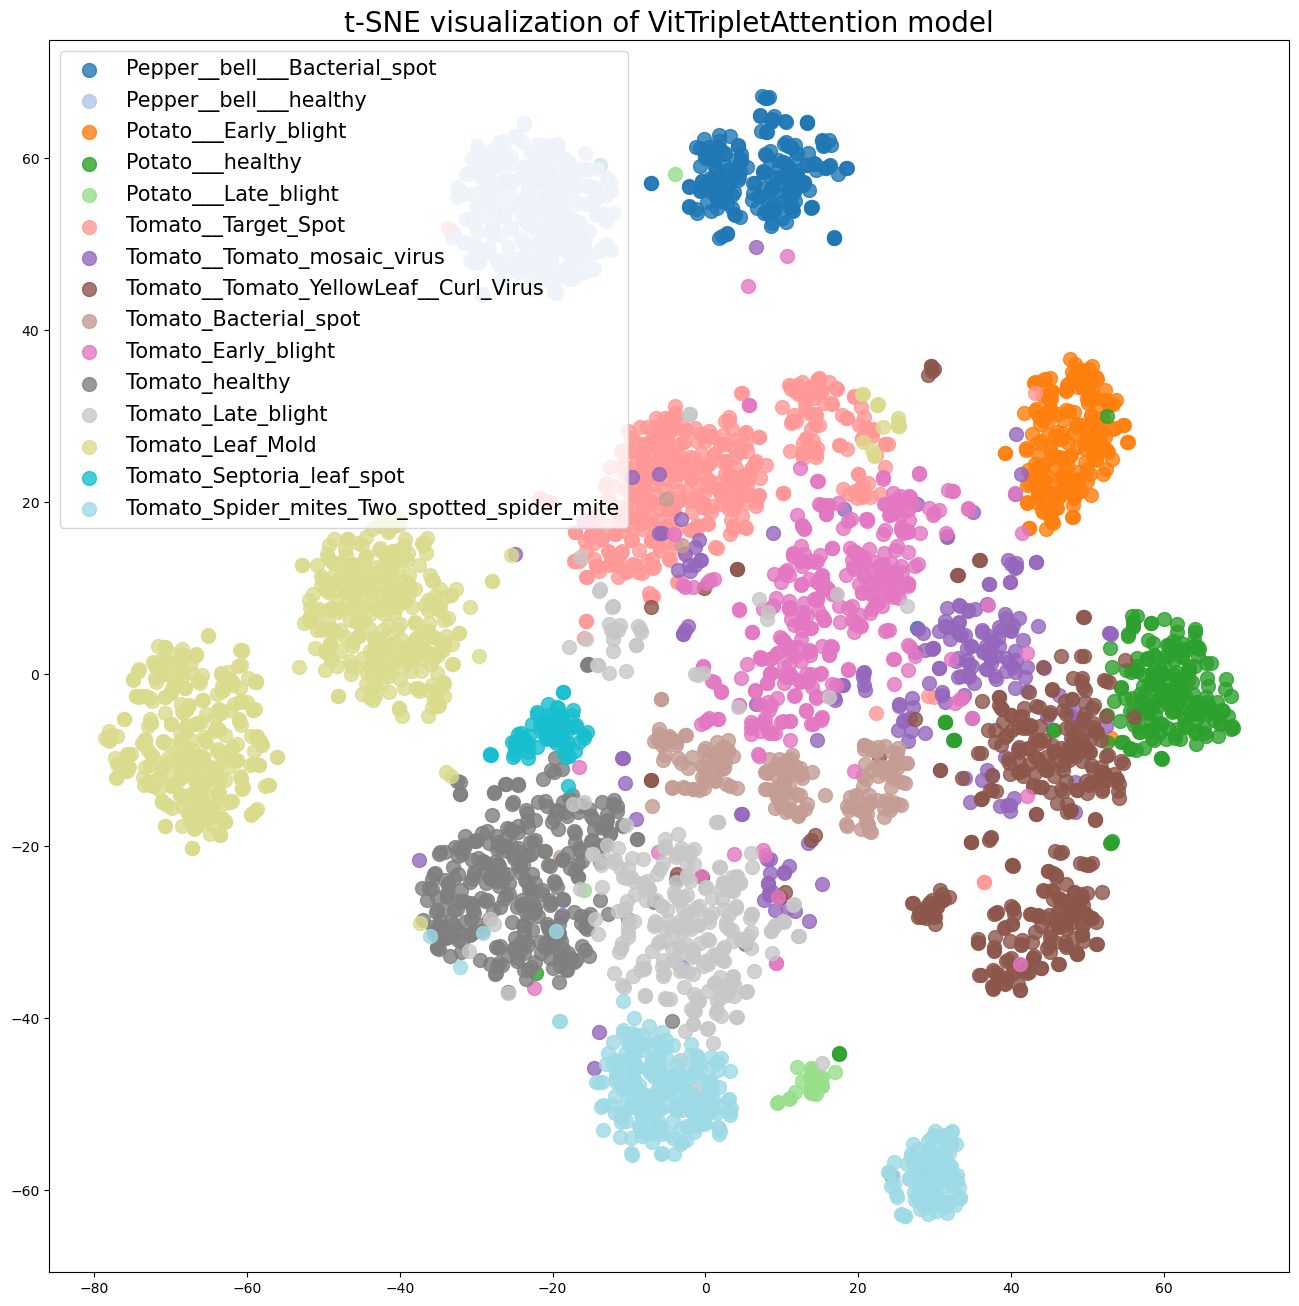

In [31]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
import CustomeTsne

# بارگذاری داده ها و استفاده از کد
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
test_dir = os.path.join(data_dir, "test")
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset و DataLoader
test_triplet_dataset = TripletDatasetFinal(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

# فراخوانی تابع
vis_tSNE(model, test_loader, device, backbone='VitTripletAttention')


In [4]:
from torchvision import transforms
from PIL import Image
import torch
from metrics import MetricsFinal
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal


# تعریف پیش پردازش تصویر (باید مشابه با پیش پردازش داده های آموزشی باشد)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    transforms.ToTensor(),  # تبدیل تصویر به تنسور
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی تصویر
])

# بارگذاری تصویر
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Potato___Early_blight/"+"0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.jpg"
image = Image.open(image_path).convert("RGB")

# اعمال پیش پردازش
image = transform(image).unsqueeze(0)  # unsqueeze برای اضافه کردن بعد batch_size (1,)
# بارگذاری مدل ( مدل قبلاً آموزش دیده و ذخیره شده است)
model = ViTWithAttention("google/vit-base-patch16-224")
#model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن های مدل
model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth"))  # بارگذاری وزن های مدل

# قرار دادن مدل در حالت ارزیابی
model.eval()
# عبور تصویر از مدل برای دریافت ویژگی های CLS Token
with torch.no_grad():  # غیرفعال کردن محاسبات گرادیان
    outputs,_ = model(image)  # عبور تصویر از مدل

# ویژگی های CLS Token از آخرین لایه
cls_features = outputs  # در مدل  این ویژگی ها از لایه attention  دریافت می شود
print(cls_features)

C:\Users\Mey\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Mey\AppData\Local\Temp\ipykernel_824\3531417481.py:32: FutureWarning: You are using `t

tensor([[ 7.8958e-01,  2.2101e-01,  8.9326e-01,  3.8026e-01,  8.0018e-03,
          7.2514e-01, -4.9694e-02,  1.0349e+00, -6.6129e-01,  5.6631e-01,
         -5.3823e-01, -2.1476e-01,  4.3147e-01, -6.4072e-01, -3.0391e-01,
         -2.0653e-01, -9.0141e-01,  2.3789e-01, -4.8395e-01, -1.4089e+00,
         -1.0319e+00,  4.8597e-02, -1.3210e-01, -9.6233e-01,  2.9791e-01,
          8.6804e-03,  6.6198e-01,  7.8880e-01,  7.4957e-01, -4.7047e-02,
          4.2809e-01,  6.3205e-01, -4.6029e-01,  6.1854e-01,  4.6977e-02,
         -1.2275e-01, -7.1889e-01, -2.0857e-01, -1.2071e+00,  2.1094e-01,
          4.9043e-01,  3.7748e-01,  1.3525e+00, -2.6716e-01,  6.9706e-02,
          4.9769e-01,  7.4458e-01,  2.3605e-01, -1.0593e+00,  1.1174e+00,
         -1.2523e+00, -2.3902e-02,  7.0356e-01,  9.5977e-01, -1.0565e+00,
          1.0086e+00, -9.6995e-01,  1.7439e+00,  1.1837e+00, -5.0900e-01,
          2.5019e-01, -3.0881e-01,  1.4434e+00,  7.2298e-01,  1.1122e+00,
         -9.3604e-01, -1.3928e+00,  1.

In [10]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import os
from torchvision.datasets import ImageFolder

# 1. تعریف transform برای پیش پردازش تصویر
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصاویر به 224x224
    ToTensor(),  # تبدیل تصاویر به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])

# 2. تابع برای محاسبه ویژگی های مرجع هر کلاس
def compute_reference_features(model, train_loader, train_dataset):
    model.eval()  # مدل را در حالت evaluation قرار دهید
    reference_features = {}  # دیکشنری برای ذخیره ویژگی های مرجع هر کلاس

    # حلقه روی تمام کلاس ها
    for cls_idx, cls in enumerate(train_dataset.classes):
        cls_features = []  # لیست برای ذخیره ویژگی های تمام تصاویر این کلاس

        # حلقه روی تمام تصاویر این کلاس
        for batch in train_loader:
            anchor, positive, negative, anchor_label = batch

            # فقط تصاویر مربوط به کلاس فعلی را انتخاب کنید
            mask = (anchor_label == cls_idx)  # ایجاد ماسک برای تصاویر این کلاس
            if mask.any():  # اگر حداقل یک تصویر از این کلاس وجود دارد
                with torch.no_grad():
                    features = model.get_embedding(anchor[mask])  # استخراج ویژگی ها
                    cls_features.append(features)

        # میانگین ویژگی های این کلاس
        if cls_features:  # اگر لیست خالی نبود
            cls_features = torch.cat(cls_features, dim=0)  # تبدیل لیست به تانسور
            reference_features[cls] = cls_features.mean(dim=0)  # میانگین ویژگی ها

    return reference_features

# 3. تابع برای پیش بینی کلاس تصویر
def predict_image_class(image_path, model, transform, reference_features, train_dataset):
    # بارگذاری تصویر
    image = Image.open(image_path).convert("RGB")
    
    # پیش پردازش تصویر
    image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch
    
    # استخراج ویژگی ها
    with torch.no_grad():
        features = model.get_embedding(image_tensor)
    
    # محاسبه فاصله ها با کلاس های مختلف
    distances = {}
    for cls, ref_feature in reference_features.items():
        distance = F.pairwise_distance(features, ref_feature.unsqueeze(0))  # محاسبه فاصله
        distances[cls] = distance.item()
    
    # پیدا کردن کلاس با کمترین فاصله
    predicted_class = min(distances, key=distances.get)
    
    return predicted_class

# 4. بارگذاری مدل آموزش دیده
# model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model = torch.load(model_path)
model.eval()  # مدل را در حالت evaluation قرار دهید

# 5. بارگذاری داده های آموزش
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
train_dir = os.path.join(data_dir, "train")
train_dataset = ImageFolder(train_dir)
train_triplet_dataset = TripletDatasetFinal(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

# 6. محاسبه ویژگی های مرجع
reference_features = compute_reference_features(model, train_loader, train_dataset)


# 7. تست تابع با یک تصویر نمونه
# بارگذاری تصویر
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Potato___Early_blight/"+"0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.jpg"
predicted_class = predict_image_class(image_path, model, transform, reference_features, train_dataset)
print(f"Predicted Class: {predicted_class}")

Predicted Class: Potato___Early_blight


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# تعریف لایه‌ی توجه (AttentionLayer)
# class AttentionLayer(nn.Module):
#     def __init__(self, feature_dim):
#         super(AttentionLayer, self).__init__()
#         self.attention = nn.Sequential(
#             nn.Linear(feature_dim, feature_dim // 2),
#             nn.ReLU(),
#             nn.Linear(feature_dim // 2, 1),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         attention_weights = self.attention(x)  # (batch_size, sequence_length, 1)
#         weighted_features = x * attention_weights  # (batch_size, sequence_length, feature_dim)
#         return weighted_features.sum(dim=1), attention_weights  # بازگرداندن وزن‌های توجه

# # تعریف مدل ViT با لایه‌ی توجه
# class ViTWithAttention(nn.Module):
#     def __init__(self, model_name):
#         super(ViTWithAttention, self).__init__()
#         self.vit = ViTModel.from_pretrained(model_name)
#         self.attention = AttentionLayer(self.vit.config.hidden_size)

#     def forward(self, x):
#         outputs = self.vit(x)
#         last_hidden_state = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
#         features, attention_weights = self.attention(last_hidden_state)  # (batch_size, hidden_size), (batch_size, sequence_length, 1)
#         return features, attention_weights

# تابع ایجاد نقشه حرارتی
def create_heatmap(image, attention_weights, patch_size=16):
    # ابعاد تصویر اصلی
    H, W, _ = image.shape
    
    # ابعاد وزن های توجه
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # تبدیل وزن های توجه به ابعاد پچ ها
    attention_weights = attention_weights.squeeze().cpu().numpy()  # حذف ابعاد اضافی
    attention_weights = attention_weights.reshape(num_patches_h, num_patches_w)
    
    # افزایش اندازه نقشه حرارتی به ابعاد تصویر اصلی
    heatmap = cv2.resize(attention_weights, (W, H), interpolation=cv2.INTER_CUBIC)
    
    return heatmap

# تابع نمایش نقشه حرارتی روی تصویر
def visualize_attention(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    
    # نمایش نقشه حرارتی روی تصویر
    plt.imshow(heatmap, alpha=0.5, cmap='jet')  # alpha برای شفافیت
    plt.colorbar()  # نمایش رنگ های نقشه حرارتی
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()

# بارگذاری تصویر اصلی
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Potato___Early_blight/"+"0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.jpg"مسیر تصویر
image = Image.open(image_path).convert("RGB")  # تبدیل به RGB
image = np.array(image)  # تبدیل به آرایه NumPy

# تبدیل تصویر به تانسور و پیش پردازش
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    ToTensor(),  # تبدیل به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])
image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch

# تعریف مدل و استخراج وزن‌های توجه
#model = ViTWithAttention(model_name="google/vit-base-patch16-224")
# model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model = torch.load(model_path)
with torch.no_grad():
    _, attention_weights = model(image_tensor)  # وزن های توجه را دریافت میکنیم

# ایجاد نقشه حرارتی
heatmap = create_heatmap(image, attention_weights, patch_size=16)
 
# نمایش نقشه حرارتی روی تصویر
visualize_attention(image, heatmap)
 

SyntaxError: invalid syntax (2229692624.py, line 71)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Mey\AppData\Local\Temp\ipykernel_8612\1241717548.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mo

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 1])
w224*h224


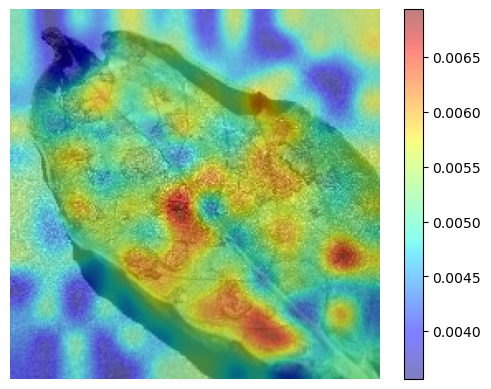

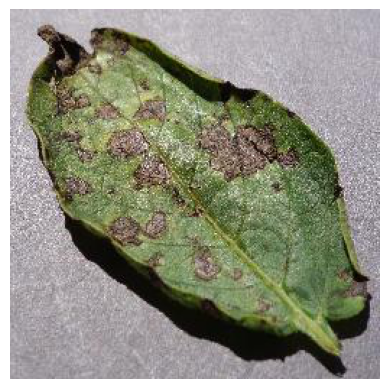

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import os
from torchvision.datasets import ImageFolder
from PIL import Image

#   بارگذاری مدل آموزش دیده
#model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention1.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention1.pth"
# model = torch.load(model_path)
model = ViTWithAttention("google/vit-base-patch16-224")
# #model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState12.pth"))  # بارگذاری وزن های مدل
model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState12.pth", map_location=torch.device('cpu')))  # بارگذاری وزن های مدل

model.eval()  # مدل را در حالت evaluation قرار دهید

# تابع ایجاد نقشه حرارتی
def create_heatmap(image, attention_weights, patch_size=16):
    # ابعاد تصویر اصلی
    _,_,W, H = image.shape  # PIL.Image از متد size استفاده می کند
    print(f"w{W}*h{H}")
    # ابعاد وزن های توجه
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # تبدیل وزن های توجه به ابعاد پچ ها
    attention_weights = attention_weights.squeeze().cpu().numpy()  # حذف ابعاد اضافی
    
    # حذف توکن کلاس (اولین توکن)
    attention_weights = attention_weights[1:]  # از توکن دوم به بعد
    
    # بررسی ابعاد
    expected_num_patches = num_patches_h * num_patches_w
    if attention_weights.shape[0] != expected_num_patches:
        raise ValueError(f"تعداد وزن‌های توجه ({attention_weights.shape[0]}) با تعداد پچ‌ها ({expected_num_patches}) مطابقت ندارد.")
    
    # تغییر شکل وزن‌های توجه به ابعاد پچ‌ها
    attention_weights = attention_weights.reshape(num_patches_h, num_patches_w)
    
    # افزایش اندازه نقشه حرارتی به ابعاد تصویر اصلی
    heatmap = cv2.resize(attention_weights, (W, H), interpolation=cv2.INTER_CUBIC)
    
    return heatmap



# تابع نمایش نقشه حرارتی روی تصویر
def visualize_attention1(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    
    # نمایش نقشه حرارتی روی تصویر
    plt.imshow(heatmap, alpha=0.5, cmap='jet')  # alpha برای شفافیت
    plt.colorbar()  # نمایش رنگ های نقشه حرارتی
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()
    
def visualize_attention2(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()    

def visualize_attention(image, heatmap):
    # ایجاد یک گرید با دو ستون
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # نمایش تصویر اصلی در سمت چپ
    axes[0].imshow(image)
    axes[0].set_title("تصویر اصلی")
    axes[0].axis('off')  # غیرفعال کردن محورها
    
    # نمایش نقشه حرارتی در سمت راست
    axes[1].imshow(image)
    axes[1].imshow(heatmap,alpha=0.5,  cmap='jet')
    axes[1].set_title("نقشه حرارتی")
    axes[1].axis('off')  # غیرفعال کردن محورها
    
    # نمایش گرید
    plt.show()    
    
# بارگذاری تصویر اصلی
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Potato___Early_blight/"+"0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.jpg" 
image = Image.open(image_path).convert("RGB")  # تبدیل به RGB

# تبدیل تصویر به تانسور و پیش پردازش
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    ToTensor(),  # تبدیل به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])
image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch
print(image_tensor.shape) 

# تعریف مدل و استخراج وزن های توجه
#model = ViTWithAttention(model_name="google/vit-base-patch16-224")
# model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model = torch.load(model_path)
with torch.no_grad():
    _, attention_weights = model(image_tensor)  # وزن های توجه را دریافت میکنیم

print(attention_weights.shape)
# ایجاد نقشه حرارتی
heatmap = create_heatmap(image_tensor, attention_weights, patch_size=16)
 
# نمایش نقشه حرارتی روی تصویر
visualize_attention1(image, heatmap)
visualize_attention2(image, heatmap)
#visualize_attention(image, heatmap)
 

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Mey\AppData\Local\Temp\ipykernel_8612\2070026131.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mo

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 1])
w224*h224


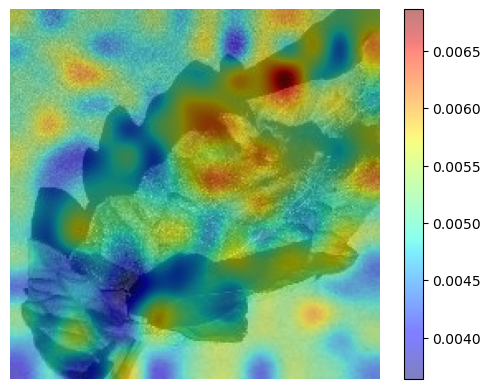

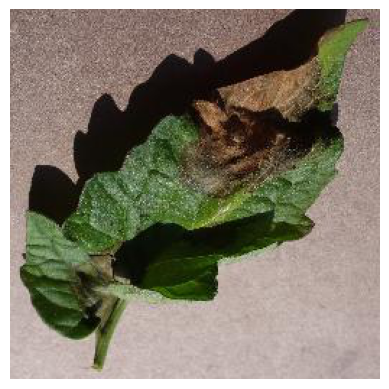

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0,'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/') 
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import TripletDatasetFinal
from attention import AttentionLayer
from models import ViTWithAttention
from losses import TripletLossFinal
import os
from torchvision.datasets import ImageFolder
from PIL import Image

#   بارگذاری مدل آموزش دیده
#model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention1.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention1.pth"
# model = torch.load(model_path)
model = ViTWithAttention("google/vit-base-patch16-224")
# #model.load_state_dict(torch.load("f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState12.pth"))  # بارگذاری وزن های مدل
model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState12.pth", map_location=torch.device('cpu')))  # بارگذاری وزن های مدل

model.eval()  # مدل را در حالت evaluation قرار دهید

# تابع ایجاد نقشه حرارتی
def create_heatmap(image, attention_weights, patch_size=16):
    # ابعاد تصویر اصلی
    _,_,W, H = image.shape  # PIL.Image از متد size استفاده می کند
    print(f"w{W}*h{H}")
    # ابعاد وزن های توجه
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # تبدیل وزن های توجه به ابعاد پچ ها
    attention_weights = attention_weights.squeeze().cpu().numpy()  # حذف ابعاد اضافی
    
    # حذف توکن کلاس (اولین توکن)
    attention_weights = attention_weights[1:]  # از توکن دوم به بعد
    
    # بررسی ابعاد
    expected_num_patches = num_patches_h * num_patches_w
    if attention_weights.shape[0] != expected_num_patches:
        raise ValueError(f"تعداد وزن‌های توجه ({attention_weights.shape[0]}) با تعداد پچ‌ها ({expected_num_patches}) مطابقت ندارد.")
    
    # تغییر شکل وزن‌های توجه به ابعاد پچ‌ها
    attention_weights = attention_weights.reshape(num_patches_h, num_patches_w)
    
    # افزایش اندازه نقشه حرارتی به ابعاد تصویر اصلی
    heatmap = cv2.resize(attention_weights, (W, H), interpolation=cv2.INTER_CUBIC)
    
    return heatmap



# تابع نمایش نقشه حرارتی روی تصویر
# def visualize_attention(image, heatmap):
#     # نمایش تصویر اصلی
#     plt.imshow(image)
    
#     # نمایش نقشه حرارتی روی تصویر
#     plt.imshow(heatmap, alpha=0.5, cmap='jet')  # alpha برای شفافیت
#     plt.colorbar()  # نمایش رنگ های نقشه حرارتی
#     plt.axis('off')  # غیرفعال کردن محورها
#     plt.show()

def visualize_attention1(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    
    # نمایش نقشه حرارتی روی تصویر
    plt.imshow(heatmap, alpha=0.5, cmap='jet')  # alpha برای شفافیت
    plt.colorbar()  # نمایش رنگ های نقشه حرارتی
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()
    
def visualize_attention2(image, heatmap):
    # نمایش تصویر اصلی
    plt.imshow(image)
    plt.axis('off')  # غیرفعال کردن محورها
    plt.show()  
    
def visualize_attention(image, heatmap):
    # ایجاد یک گرید با دو ستون
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # نمایش تصویر اصلی در سمت چپ
    axes[0].imshow(image)
    axes[0].set_title("تصویر اصلی")
    axes[0].axis('off')  # غیرفعال کردن محورها
    
    # نمایش نقشه حرارتی در سمت راست
    axes[1].imshow(image)
    axes[1].imshow(heatmap,alpha=0.5,  cmap='jet')
    axes[1].set_title("نقشه حرارتی")
    axes[1].axis('off')  # غیرفعال کردن محورها
    
    # نمایش گرید
    plt.show()
    

# بارگذاری تصویر اصلی
#data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
image_path = data_dir+"/test/Tomato_Late_blight/"+"0ac3df5b-d713-42ef-b0ad-20b5410237ad___RS_Late.B 4969.JPG" 
image = Image.open(image_path).convert("RGB")  # تبدیل به RGB

# تبدیل تصویر به تانسور و پیش پردازش
transform = Compose([
    Resize((224, 224)),  # تغییر اندازه تصویر به 224x224
    ToTensor(),  # تبدیل به تانسور
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال سازی
])
image_tensor = transform(image).unsqueeze(0)  # اضافه کردن بعد batch
print(image_tensor.shape) 

# تعریف مدل و استخراج وزن های توجه
#model = ViTWithAttention(model_name="google/vit-base-patch16-224")
# model_path = "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model_path = "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth"
# model = torch.load(model_path)
with torch.no_grad():
    _, attention_weights = model(image_tensor)  # وزن های توجه را دریافت میکنیم

print(attention_weights.shape)
# ایجاد نقشه حرارتی
heatmap = create_heatmap(image_tensor, attention_weights, patch_size=16)
 
# نمایش نقشه حرارتی روی تصویر
visualize_attention1(image, heatmap)
visualize_attention2(image, heatmap)
# visualize_attention(image, heatmap)